In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import gc

import warnings
warnings.filterwarnings('ignore')

# ====================================================
# Directory settings
# ====================================================
OUTPUT_DIR = './output/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
import os
def is_colab_env():
    is_colab = False
    for k in os.environ.keys():
        if "COLAB" in k:
            is_colab = True
            break
    return is_colab

# if google colab, install transformers and tensorflow_addons
# (Note: please use google colab(TPU) when model is trained. 
#  On the kaggle TPU env, the module transformers.TFCLIPVisionModel couldn't be installed.)
if is_colab_env():
    !pip install transformers
    !pip install tensorflow_addons

In [2]:
from transformers import CLIPProcessor, TFCLIPVisionModel, CLIPFeatureExtractor

import re
import os
import glob
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime
import gc
import requests
from mpl_toolkits import axes_grid1

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

# If GPU instance, it makes mixed precision enable.
if strategy.num_replicas_in_sync == 1:
    from tensorflow.python.keras.mixed_precision.policy import set_global_policy
    set_global_policy('mixed_float16')
    # from tensorflow.keras.mixed_precision import experimental as mixed_precision
    # policy = mixed_precision.Policy('mixed_float16')
    # mixed_precision.set_policy(policy) 

In [4]:
class config:
    VERSION = 3
    SUBV = "Clip_ViT_Train"

    SEED = 456

    # pretrained model
    RESUME = False
    #RESUME_EPOCH = 0
    #RESUME_WEIGHT = "../input/guei-v6-clip-vit-large-arcface-train-projection/clip-vit-large-patch14_224pix-emb256_arcface_entire.h5"

    # backbone model
    MODEL_NAME = 'CLIP-ViT-H-14-laion2B-s32B-b79K' # "CLIP-ViT-g-14-laion2B-s12B-b42K"
    IMAGE_SIZE = 224

    # projection layer
    N_CLASSES = 17691  # 9691 + 8876 + 38412 + 7980  # 17691
    EMB_DIM = 64  # = 64 x N
    
    # training
    TRAIN = True
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    EPOCHS = 25
    LR = 0.001
    save_dir = OUTPUT_DIR+""
    DEBUG = False
    

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# model name
print(config.MODEL_NAME)

In [ ]:
if is_colab_env(): # for google colab env.
    kaggle_backet_dict = {
        "guie-products10k-tfrecords-label-1000-10690" : "gs://kds-4fa025a74361a0e6982670304fadbe3983eaedbef67dd6ebb90cefc1",
        "guie-glr2021mini-tfrecords-label-10691-17690" : "gs://kds-ff2615c7bf59c8b39ebee8c7740a9924e69790644efc69f554fefcca",
    }
else: # for kaggle notebook
    from kaggle_datasets import KaggleDatasets

In [5]:
train_shard_suffix = '*-train-*.tfrec'

ROOT_DIRS  = [
    "guie-glr2021mini-tfrecords-label-10691-17690",
    "guie-products10k-tfrecords-label-1000-10690",
]

train_set_path = []
valid_set_path = []
for ROOT_DIR in ROOT_DIRS:
    if is_colab_env():
        GCS_DS_PATH = kaggle_backet_dict[ ROOT_DIR ]
    else:
        GCS_DS_PATH = KaggleDatasets().get_gcs_path( ROOT_DIR )
        
    print( f"\"{ROOT_DIR}\" : \"{GCS_DS_PATH}\"," )
    files = sorted(tf.io.gfile.glob(GCS_DS_PATH + f'/{train_shard_suffix}'))
    # split data
    train_set_path += random.sample(files, int( len(files) * 1 ) )
    valid_set_path +=random.sample(files, int( len(files) * 0.04 ) )
    print(ROOT_DIR, ", number of tfrecords = ", len(files))

train_set_path = sorted( train_set_path )
valid_set_path = sorted( valid_set_path )

print("# of tfrecords for training   : ", len(train_set_path))
print("# of tfrecords for validation : ", len(valid_set_path))

if config.DEBUG:
    train_set_path = random.sample( train_set_path, 4)
    print("debug: reduce training data. num=", len(train_set_path))
    
    valid_set_path = train_set_path #valid_set_path[:1]
    print("debug: reduce validation data. num=", len(valid_set_path))

In [6]:
def get_num_of_image(file):
    return int(file.split("/")[-1].split(".")[0].split("-")[-1])

train_set_len = sum( [ get_num_of_image(file) for file in train_set_path ] )
valid_set_len = sum( [ get_num_of_image(file) for file in valid_set_path ] )

train_set_len, valid_set_len

In [7]:
def deserialization_fn(serialized_example):
    parsed_example = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        }
    )
    image = tf.image.decode_jpeg(parsed_example['image/encoded'], channels=3)
    image = tf.image.resize(image, size=(config.IMAGE_SIZE, config.IMAGE_SIZE))
    label = tf.cast(parsed_example['image/class/label'], tf.int64)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [8]:
# One in K chance function
def tf_rand_int(minval, maxval, dtype=tf.int64):
    minval = tf.cast(minval, dtype)
    maxval = tf.cast(maxval, dtype)
    return tf.random.uniform(shape=(), minval=minval, maxval=maxval, dtype=dtype)

def one_in(k):
    return 0 == tf_rand_int(0, k)

In [9]:
def arcface_format(image, label_group):
    return {'inp1': image, 'inp2': label_group}, label_group

def rescale_image(image, label_group):
    image = tf.cast(image, tf.float32) * 255.0
    return image, label_group

# Data augmentation function
def data_augment(image, label_group):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image, label_group

# Dataset to obtain backbone's inference
def get_backbone_inference_dataset(tfrecord_paths, cache=False, repeat=False, shuffle=False, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(tfrecord_paths)
    data_len = sum( [ get_num_of_image(file) for file in tfrecord_paths ] )
    dataset = dataset.shuffle( data_len ) if shuffle else dataset
    dataset = dataset.flat_map(tf.data.TFRecordDataset)
    dataset = dataset.map(deserialization_fn, num_parallel_calls=AUTO) # image[0-1], label[0-999]

    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)  # (image, label_group) --> (image, label_group)
    dataset = dataset.map(rescale_image, num_parallel_calls = AUTO)  # image[0-1], label[0-n_classes] --> image[0-255], label[0-n_classes]
    dataset = dataset.map(arcface_format, num_parallel_calls=AUTO)   # (image, label_group) --> ({"inp1":image, "inp2":label_group}, label_group )
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [10]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, k=3, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m
        self.k = k

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes*self.k),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        cosine = tf.reshape(cosine, [-1, self.n_classes, self.k])
        cosine = tf.math.reduce_max(cosine, axis=2)
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [11]:
def get_scale_layer(rescale_mode = "tf"):
    # For keras_cv_attention_models module:
    # ref: https://github.com/leondgarse/keras_cv_attention_models/blob/main/keras_cv_attention_models/imagenet/data.py
    # ref function : init_mean_std_by_rescale_mode()

    # For effV2 (21k classes) : https://github.com/leondgarse/keras_efficientnet_v2

    if isinstance(rescale_mode, (list, tuple)):  # Specific mean and std
        mean, std = rescale_mode
    elif rescale_mode == "torch":
        mean = np.array([0.48145466, 0.4578275, 0.40821073]) * 255.0
        std = np.array([0.26862954, 0.26130258, 0.27577711]) * 255.0
    elif rescale_mode == "tf":  # [0, 255] -> [-1, 1]
        mean, std = 127.5, 127.5
    elif rescale_mode == "tf128":  # [0, 255] -> [-1, 1]
        mean, std = 128.0, 128.0
    elif rescale_mode == "raw01":
        mean, std = 0, 255.0  # [0, 255] -> [0, 1]
    else:
        mean, std = 0, 1  # raw inputs [0, 255]        
    scaling_layer = keras.layers.Lambda(lambda x: ( tf.cast(x, tf.float32) - mean) / std )
    
    return scaling_layer


def get_clip_model():
    inp = tf.keras.layers.Input(shape = [3, config.IMAGE_SIZE, config.IMAGE_SIZE]) # [B, C, H, W]
    backbone = TFCLIPVisionModel.from_pretrained(f"laion/{config.MODEL_NAME}",from_pt=True)
    output = backbone({'pixel_values':inp}).pooler_output
    return tf.keras.Model(inputs=[inp], outputs=[output])

def get_embedding_model():
    #------------------
    # Definition of placeholders
    inp = tf.keras.layers.Input(shape = [None, None, 3], name = 'inp1')
    label = tf.keras.layers.Input(shape = (), name = 'inp2')

    # Definition of layers
    layer_resize = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [config.IMAGE_SIZE, config.IMAGE_SIZE]), name='resize')
    layer_scaling = get_scale_layer(rescale_mode = "torch")
    layer_permute = tf.keras.layers.Permute((3,1,2))
    layer_backbone = get_clip_model()
    
    layer_dense_before_arcface1 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface2 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface3 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface4 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface5 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface6 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface7 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface8 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface9 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface10 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface11 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface12 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface13 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface14 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface15 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface16 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface17 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface18 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface19 = tf.keras.layers.Dense(64)
    layer_dense_before_arcface20 = tf.keras.layers.Dense(64)

    
    layer_margin = ArcMarginProduct(
        n_classes = config.N_CLASSES, 
        s = 30, 
        m = 0.5, 
        k = 3,
        name=f'head/arcface', 
        dtype='float32'
        )
    layer_softmax = tf.keras.layers.Softmax(dtype='float32')
    layer_l2 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1), name='embedding_norm')
    layer_l21 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1), name='embedding_norm1')
    if config.EMB_DIM != 64:
        layer_adaptive_pooling = tfa.layers.AdaptiveAveragePooling1D(64)
    else:
        layer_adaptive_pooling = tf.keras.layers.Lambda(lambda x: x )  # layer with no operation

    #------------------
    # Definition of entire model
    image = layer_scaling(inp)
    image = layer_resize(image)
    image = layer_permute(image)
    embed = layer_backbone(image)
    embed = tf.keras.layers.Dropout(0.1)(embed)
    embed1 = layer_dense_before_arcface1(embed)
    embed1 = tf.keras.layers.Dropout(0.01)(embed1)
    embed2 = layer_dense_before_arcface2(embed)
    embed2 = tf.keras.layers.Dropout(0.02)(embed2)
    embed3 = layer_dense_before_arcface3(embed)
    embed3 = tf.keras.layers.Dropout(0.03)(embed3)
    embed4 = layer_dense_before_arcface4(embed)
    embed4 = tf.keras.layers.Dropout(0.04)(embed4)
    embed5 = layer_dense_before_arcface5(embed)
    embed5 = tf.keras.layers.Dropout(0.05)(embed5)
    embed6 = layer_dense_before_arcface6(embed)
    embed6 = tf.keras.layers.Dropout(0.06)(embed6)
    embed7 = layer_dense_before_arcface7(embed)
    embed7 = tf.keras.layers.Dropout(0.07)(embed7)
    embed8 = layer_dense_before_arcface8(embed)
    embed8 = tf.keras.layers.Dropout(0.08)(embed8)
    embed9 = layer_dense_before_arcface9(embed)
    embed9 = tf.keras.layers.Dropout(0.09)(embed9)
    embed10 = layer_dense_before_arcface10(embed)
    embed10 = tf.keras.layers.Dropout(0.10)(embed10)
    embed11 = layer_dense_before_arcface11(embed)
    embed11 = tf.keras.layers.Dropout(0.11)(embed11)
    embed12 = layer_dense_before_arcface12(embed)
    embed12 = tf.keras.layers.Dropout(0.12)(embed12)
    embed13 = layer_dense_before_arcface13(embed)
    embed13 = tf.keras.layers.Dropout(0.13)(embed13)
    embed14 = layer_dense_before_arcface14(embed)
    embed14 = tf.keras.layers.Dropout(0.14)(embed14)
    embed15 = layer_dense_before_arcface15(embed)
    embed15 = tf.keras.layers.Dropout(0.15)(embed15)
    embed16 = layer_dense_before_arcface16(embed)
    embed16 = tf.keras.layers.Dropout(0.16)(embed16)
    embed17 = layer_dense_before_arcface17(embed)
    embed17 = tf.keras.layers.Dropout(0.17)(embed17)
    embed18 = layer_dense_before_arcface18(embed)
    embed18 = tf.keras.layers.Dropout(0.18)(embed18)
    embed19 = layer_dense_before_arcface19(embed)
    embed19 = tf.keras.layers.Dropout(0.19)(embed19)
    embed20 = layer_dense_before_arcface20(embed)
    embed20 = tf.keras.layers.Dropout(0.20)(embed20)
    
    
    embed=(embed1+embed2+embed3+embed4+embed5+embed6+embed7+embed8+embed9+embed10+embed11+embed12+embed13+embed14+embed15+embed16+embed17+embed18+embed19+embed20)/20
    
    x = layer_margin([embed, label])
    output = layer_softmax(x)
    model = tf.keras.models.Model(inputs = [inp, label], outputs = [output]) # whole architecture

    # model.layers[4].trainable = False
    opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
    model.compile(
        optimizer = opt,
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
        )

    #------------------
    # Definition of embedding model (for submission)
    
    
    inputs =tf.keras.layers.Input(shape = [None, None, 3], dtype='uint8')
    xx=layer_scaling(inputs)
    xx=layer_resize(xx)
    xx=layer_permute(xx)
    xx=layer_backbone(xx)
    xx = tf.keras.layers.Dropout(0.2)(xx)
    xx1 = layer_dense_before_arcface1(xx)
    xx1 = tf.keras.layers.Dropout(0.02)(xx1)
    xx2 = layer_dense_before_arcface2(xx)
    xx2 = tf.keras.layers.Dropout(0.04)(xx2)
    xx3 = layer_dense_before_arcface3(xx)
    xx3 = tf.keras.layers.Dropout(0.06)(xx3)
    xx4 = layer_dense_before_arcface4(xx)
    xx4 = tf.keras.layers.Dropout(0.08)(xx4)
    xx5 = layer_dense_before_arcface5(xx)
    xx5 = tf.keras.layers.Dropout(0.10)(xx5)
    xx6 = layer_dense_before_arcface6(xx)
    xx6 = tf.keras.layers.Dropout(0.12)(xx6)
    xx7 = layer_dense_before_arcface7(xx)
    xx7 = tf.keras.layers.Dropout(0.14)(xx7)
    xx8 = layer_dense_before_arcface8(xx)
    xx8 = tf.keras.layers.Dropout(0.16)(xx8)
    xx9 = layer_dense_before_arcface9(xx)
    xx9 = tf.keras.layers.Dropout(0.18)(xx9)
    xx10 = layer_dense_before_arcface10(xx)
    xx10 = tf.keras.layers.Dropout(0.20)(xx10)
    xx11 = layer_dense_before_arcface11(xx)
    xx11 = tf.keras.layers.Dropout(0.22)(xx11)
    xx12 = layer_dense_before_arcface12(xx)
    xx12 = tf.keras.layers.Dropout(0.24)(xx12)
    xx13 = layer_dense_before_arcface13(xx)
    xx13 = tf.keras.layers.Dropout(0.26)(xx13)
    xx14 = layer_dense_before_arcface14(xx)
    xx14 = tf.keras.layers.Dropout(0.28)(xx14)
    xx15 = layer_dense_before_arcface15(xx)
    xx15 = tf.keras.layers.Dropout(0.30)(xx15)
    xx16 = layer_dense_before_arcface16(xx)
    xx16 = tf.keras.layers.Dropout(0.32)(xx16)
    xx17 = layer_dense_before_arcface17(xx)
    xx17 = tf.keras.layers.Dropout(0.34)(xx17)
    xx18 = layer_dense_before_arcface18(xx)
    xx18 = tf.keras.layers.Dropout(0.36)(xx18)
    xx19 = layer_dense_before_arcface19(xx)
    xx19 = tf.keras.layers.Dropout(0.38)(xx19)
    xx20 = layer_dense_before_arcface20(xx)
    xx20 = tf.keras.layers.Dropout(0.40)(xx20)

    xx=(xx1+xx2+xx3+xx4+xx5+xx6+xx7+xx8+xx9+xx10+xx11+xx12+xx13+xx14+xx15+xx16+xx17+xx18+xx19+xx20)/20
    
    embed_model =tf.keras.models.Model(inputs=inputs, outputs=xx)
    
    return model, embed_model

In [7]:
with strategy.scope():
    model, emb_model = get_embedding_model()

model.load_weights('output/t-200.h5')

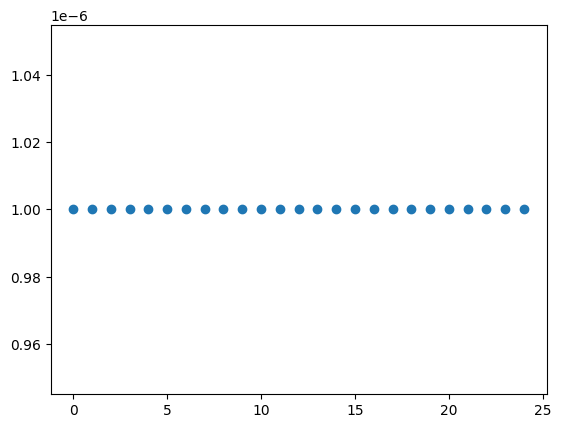

In [13]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000001
    lr_min     = 0.000001
    lr_ramp_ep = 0
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [1]:
if config.TRAIN:
    checkpoint_path = "stage2_t-{epoch:03d}.h5"
    sv_loss = tf.keras.callbacks.ModelCheckpoint(
        config.save_dir+f"/{checkpoint_path}", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=False,
        save_weights_only=True, mode='max',period=5)

    steps_per_epoch = train_set_len // config.BATCH_SIZE  // 10     # "//10" means that the lr is update every 0.1 epoch.
    validation_steps = valid_set_len // config.BATCH_SIZE 
    if valid_set_len % config.BATCH_SIZE != 0:
        validation_steps += 1
    print(steps_per_epoch, validation_steps)
    ds_train = get_backbone_inference_dataset(train_set_path, shuffle=True, augment=True, repeat=True)
    ds_valid = get_backbone_inference_dataset(valid_set_path, shuffle=False, augment=False, repeat=False)

    history = model.fit(
        ds_train,
        steps_per_epoch=steps_per_epoch,
        epochs=config.EPOCHS,
        callbacks=[get_lr_callback(), sv_loss],
        validation_data = ds_valid,
        validation_steps = validation_steps,
        verbose=1
    )
